In [15]:
import pandas as pd
import os
import sys

def leer_archivo(ruta_archivo: str):
    # Verificar que el archivo existe
    if not os.path.exists(ruta_archivo):
        sys.exit(f"❌ El archivo no existe: {ruta_archivo}")

    # Detectar la extensión
    extension = os.path.splitext(ruta_archivo)[1].lower()

    try:
        if extension == ".csv":
            df = pd.read_csv(
                ruta_archivo,
                thousands=",",         # ✅ interpreta comas como miles (2022, 20000)
                na_values=["", " "],   # ✅ vacíos como NaN
                keep_default_na=True
            )
        elif extension in [".xls", ".xlsx"]:
            df = pd.read_excel(ruta_archivo)
        elif extension == ".json":
            df = pd.read_json(ruta_archivo)
        else:
            sys.exit(f"⚠️ Tipo de archivo no soportado: {extension}")

        # Mostrar solo las primeras 10 filas
        print(df.head(10))
        return df

    except Exception as e:
        sys.exit(f"❌ Error al leer el archivo: {e}")

In [16]:
def combinar_dataframes(df1, df2, cols1=None, cols2=None, how="inner"):
    """
    Combina dos DataFrames en base a columnas comunes o especificadas.
    
    Parámetros:
    -----------
    df1 : DataFrame
        Primer DataFrame
    df2 : DataFrame
        Segundo DataFrame
    cols1 : str o list, opcional
        Columna(s) en df1 para la unión
    cols2 : str o list, opcional
        Columna(s) en df2 para la unión
    how : str, default "inner"
        Tipo de unión: 'left', 'right', 'outer', 'inner'

    Retorna:
    --------
    DataFrame combinado
    """
    if cols1 is None and cols2 is None:
        # Detectar columnas comunes automáticamente
        comunes = list(set(df1.columns) & set(df2.columns))
        if not comunes:
            raise ValueError("❌ No hay columnas en común para combinar.")
        return pd.merge(df1, df2, on=comunes, how=how)

    elif cols1 is not None and cols2 is not None:
        # Unión con columnas diferentes
        return pd.merge(df1, df2, left_on=cols1, right_on=cols2, how=how)

    else:
        raise ValueError("❌ Debes pasar ambas listas de columnas (cols1 y cols2) o ninguna.")


In [17]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-muted")  # Estilo limpio


# Ruta del archivo
ruta = "./data/estaciones.csv"
df = leer_archivo(ruta)

                  Tipo de estacion             Estación    Ciudad  \
0  Estación de carga eléctrica EPM           Aeropuerto  Rionegro   
1  Estación de carga eléctrica EPM        Éxito Poblado  Medellín   
2  Estación de carga eléctrica EPM        Éxito Poblado  Medellín   
3  Estación de carga eléctrica EPM         Exposiciones  Medellín   
4  Estación de carga eléctrica EPM     EDS Texaco Vegas  Envigado   
5  Estación de carga eléctrica EPM  1er Parque Laureles  Medellín   
6  Estación de carga eléctrica EPM  1er Parque Laureles  Medellín   
7  Estación de carga eléctrica EPM       CC Los Molinos  Medellín   
8  Estación de carga eléctrica EPM       CC Los Molinos  Medellín   
9  Estación de carga eléctrica EPM           CC Mayorca  Sabaneta   

  Tipo de carga              Horario  \
0        Rápida   12:00 pm a 11:59pm   
1   Semi Rápida    8:00 am a 8:00 pm   
2   Semi Rápida    8:00 am a 8:00 pm   
3        Rápida  12:00 pm a 11:59 pm   
4        Rápida  12:00 pm a 11:59 pm   


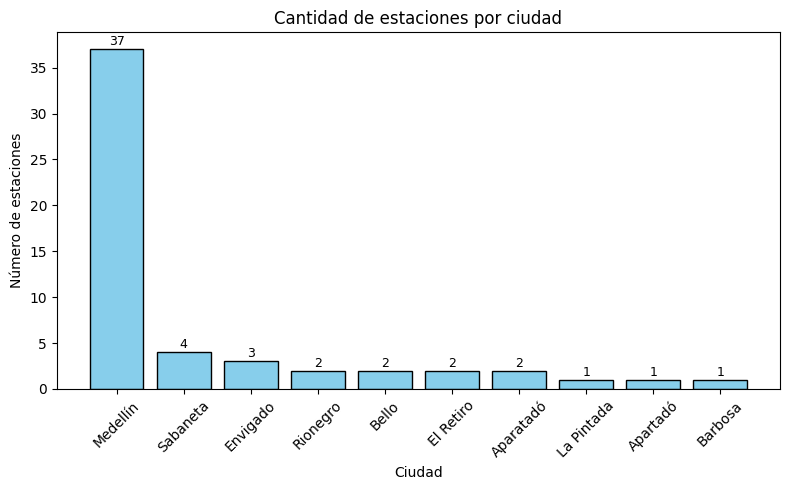

In [18]:
conteo_ciudad = df["Ciudad"].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(conteo_ciudad.index, conteo_ciudad.values, color="skyblue", edgecolor="black")
plt.title("Cantidad de estaciones por ciudad")
plt.xlabel("Ciudad")
plt.ylabel("Número de estaciones")
plt.xticks(rotation=45)

# Etiquetas encima
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, str(height),
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


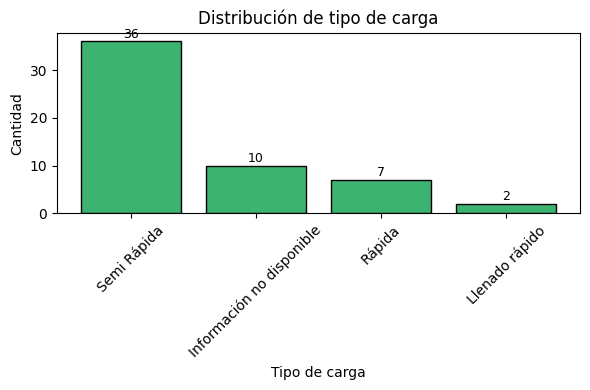

In [19]:
conteo_tipo_carga = df["Tipo de carga"].value_counts()

plt.figure(figsize=(6, 4))
bars = plt.bar(conteo_tipo_carga.index, conteo_tipo_carga.values, color="mediumseagreen", edgecolor="black")
plt.title("Distribución de tipo de carga")
plt.xlabel("Tipo de carga")
plt.ylabel("Cantidad")
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, str(height),
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

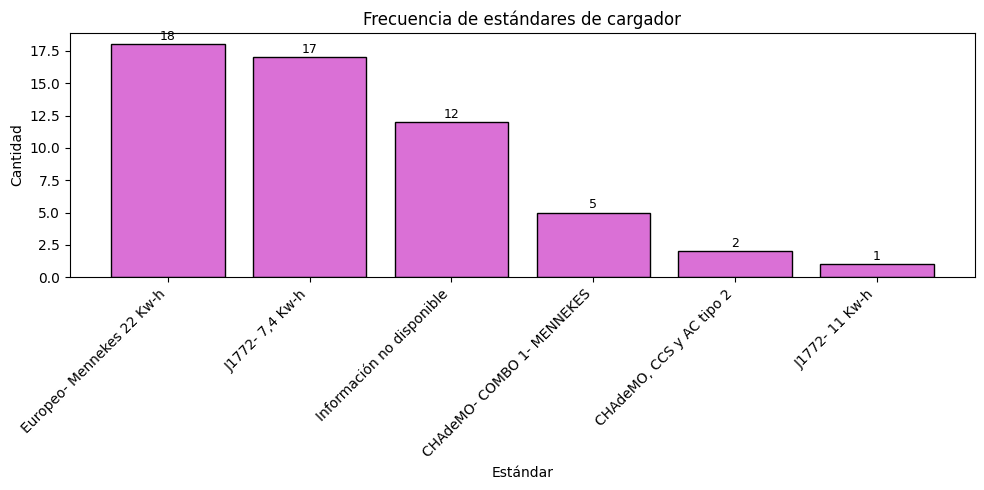

: 

In [ ]:
conteo_cargadores = df["Estándar Cargador"].value_counts()

plt.figure(figsize=(10, 5))
bars = plt.bar(conteo_cargadores.index, conteo_cargadores.values, color="orchid", edgecolor="black")
plt.title("Frecuencia de estándares de cargador")
plt.xlabel("Estándar")
plt.ylabel("Cantidad")
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, str(height),
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

# 1. Preparación de datos (igual que tu código)
df[["Lat", "Lon"]] = df["Coordenadas"].str.split(",", expand=True)
df["Lat"] = df["Lat"].astype(str).str.replace(",", ".").astype(float)
df["Lon"] = df["Lon"].astype(str).str.replace(",", ".").astype(float)

# 2. Filtrar y convertir a GeoDataFrame
df_valid = df[(df["Lat"] >= 5.5) & (df["Lat"] <= 7.5) & 
            (df["Lon"] >= -76.2) & (df["Lon"] <= -75.0)]

# Crea un GeoDataFrame a partir de las coordenadas
gdf = gpd.GeoDataFrame(
    df_valid, geometry=gpd.points_from_xy(df_valid.Lon, df_valid.Lat), crs="EPSG:4326"
)

# 3. Graficar con GeoPandas y Contextily
fig, ax = plt.subplots(figsize=(10, 10))
gdf.to_crs(epsg=3857).plot(ax=ax, color='dodgerblue', edgecolor='black', markersize=50, alpha=0.85)

# Añadir el mapa base de Contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)

# Opcional: Mostrar nombre de estación
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf["Estación"]):
    ax.text(x, y, label, fontsize=8, ha='center', va='bottom', transform=ax.transData)

# Personalización
ax.set_title("Ubicación de estaciones de carga eléctrica (Antioquia - Colombia)", fontsize=14)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.grid(True)
plt.show()

In [ ]:
conteo_horarios = df["Horario"].value_counts()

plt.figure(figsize=(10, 5))
bars = plt.bar(conteo_horarios.index, conteo_horarios.values, color="coral", edgecolor="black")
plt.title("Horarios de funcionamiento de estaciones")
plt.xlabel("Horario")
plt.ylabel("Cantidad")
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, str(height),
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()